In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, 1, -1], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def plot(c1s, c2s, c3s, u_errors, g1, g2, g3, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(g1, ils[0], ils[-1], label="g1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs g1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(g2, ils[0], ils[-1], label="g2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs g2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.hlines(g3, ils[0], ils[-1], label="g3", color="black")
    ax.plot(ils, c3s, label="c3")
    ax.legend()
    ax.set_title("c3 vs g3")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 1]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    sigma, rho, beta = gs

    x, y, z = true

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    sigma, rho, beta = cs

    x, y, z = nudged

    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


# System evolution parameters
sigma, rho, beta = g1, g2, g3 = 10, 28, 8 / 3
c1, c2, c3 = g1, g2, g3
c1 *= 1.1
c2 *= 0.9
c3 *= 1.1
mu = 20

gs = jnp.array([g1, g2, g3])
bs = jnp.array([])
cs = jnp.array([c1, c2, c3])

observed_slice = jnp.s_[:]
system = System_ModelKnown(
    mu, gs, bs, cs, observed_slice, assimilated_ode, true_ode
)

solver = ti.ForwardEuler(system)
# solver = ti.RK4(system)
solver = ti.TwoStepAdamsBashforth(system, solver)
# optimizer = base_optim.LevenbergMarquardt(system, 1e-2)
optimizer = optax.adam(1e-1)
optimizer = optim.OptaxWrapper(system, optimizer)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 200
t_relax = 1

true0, assimilated0 = get_initial_values()

true_solver = solver
true, tls_ = true_solver.solve_true(true0, T0, Tf, dt)

true_observed = true[:, system.observed_slice]

In [ ]:
cs, u_errors, tls, *_ = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer=optimizer,
    tls_=tls_,
)

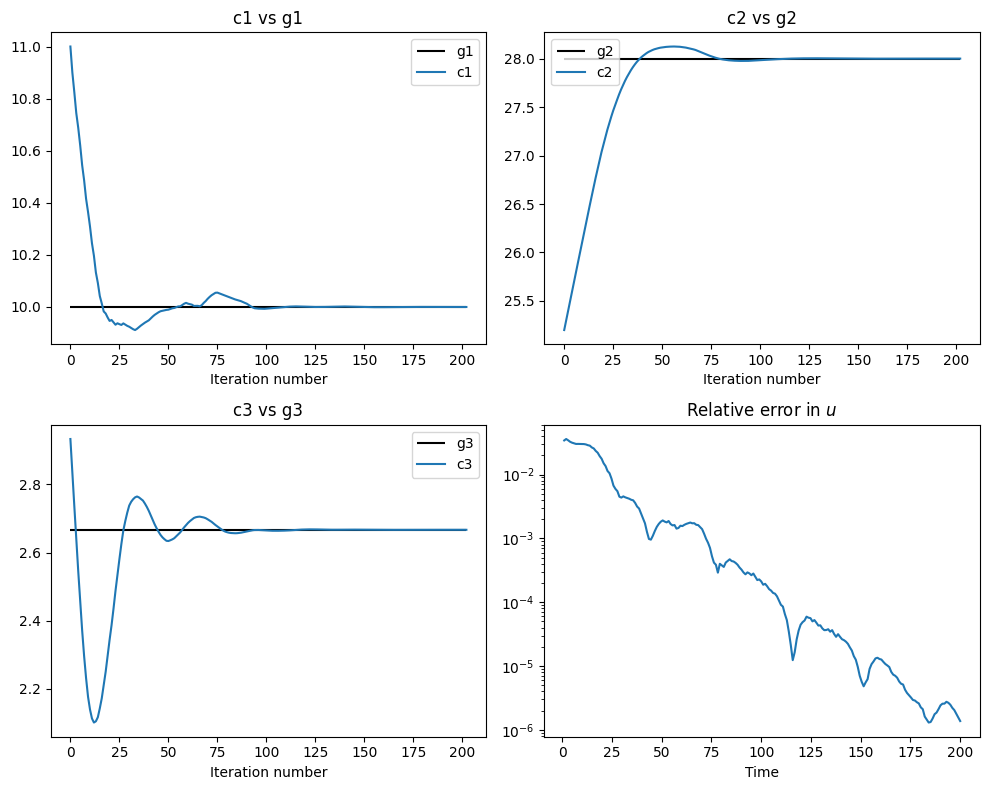

In [ ]:
fig, axs = plot(cs.T[0], cs.T[1], cs.T[2], u_errors, g1, g2, g3, tls)
plt.show()